                                                                    Pablo Tejero 

Load the packages, and import the different functions

In [86]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
import graphviz
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from ydata_profiling import ProfileReport
import seaborn as sns


Define a function which is going through the data, finding the outliers of each column, and sustitute them by the mean value

In [87]:
def CustomSampler_IQR(X, y):
    df = X.copy()
    features = X.columns
    
    for col in features:
        Q1 = np.nanpercentile(df[col], 25.)
        Q3 = np.nanpercentile(df[col], 75.)
        # Define cut off
        cut_off = (Q3 - Q1) * 1.5
        # Define the threshold
        upper, lower = Q3 + cut_off, Q1 - cut_off
        # Find the outliers for each column
        outliers_mask = (df[col] < lower) | (df[col] > upper)
        # Find median of each column
        median = np.nanmedian(df[col])
        # Modify the outliers by the median value  
        df[col] = np.where(outliers_mask, median, df[col])

    X_clean = df
    y_clean = y.loc[df.index]
    
    return X_clean, y_clean

# Pre-processing

Load the data in two variables: PGS_results and Phenotype_essential

In [88]:
PGS_results = pd.read_csv('PGS_results.tsv', delimiter='\t')
Phenotype_essential = pd.read_csv('Phenotype_essential.tsv', delimiter='\t')

Create a profile, with data description and plots in HTML. It is commented because it take to much time

In [89]:
#profile_PGS = ProfileReport(PGS_results, title="Profiling Report")
#profile_PGS.to_file("your_report.html")


Compare the presence of samples with the same SampleID, saving just them for the later analysis.

In [90]:
# Merge the data based on the SampleID 
merged = pd.merge(PGS_results, Phenotype_essential, on='SampleID', how='inner')

# Go through both datasets and save just those samples that are present in both of them, saving them in two variables.
pgs_filtered = PGS_results[PGS_results['SampleID'].isin(merged['SampleID'])]
phenotype_filtered = Phenotype_essential[Phenotype_essential['SampleID'].isin(merged['SampleID'])]


Check for duplicate values

In [91]:
sum(pgs_filtered["SampleID"].duplicated())

1

There were two sample with the same SampleID, delete one and mantain the other.

In [92]:
pgs_filtered = pgs_filtered.drop_duplicates(subset='SampleID', keep='first')

Check there are no  other duplicated SamplesID values 

In [93]:
sum(pgs_filtered["SampleID"].duplicated())

0

Show the shape of the filtered datasets

In [94]:
# Print the values, to check they have the same number of samples
print("Filtered values:")
(pgs_filtered.shape, phenotype_filtered.shape)

Filtered values:


((837, 47), (837, 4))

Establish the X variable (just to simplify), and y for just the traject column. 

In [95]:
X = pgs_filtered
y = phenotype_filtered['Traject']


Delete SampleID and UniqueID columns.

In [96]:
X = X.drop(['SampleID', 'UniqueID'], axis=1)

Replace the NaN values by the median values. 

In [97]:
median = y.median()
y = y.fillna(median)
y

1      3.0
2      3.0
3      3.0
4      3.0
5      3.0
      ... 
917    3.0
918    3.0
919    3.0
920    3.0
921    3.0
Name: Traject, Length: 837, dtype: float64

Restart the index in X and y, so both of them have the same one

In [98]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

Use the above function to obtain X and Y with no outliers

In [99]:
X_clean, y_clean = CustomSampler_IQR(X, y)

Now we are going to check the data is complete

In [100]:
missing_values_PGS = X_clean.isnull()
missing_values_Phenotype = y_clean.isnull()

#print(missing_values_PGS.sum())
print(missing_values_Phenotype.sum())

0


Now we split both the training and the test set, in X and y, the y with the objective function, in this case, the column traject.

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)
print("Training data:", X_train.shape)
print("Test data:", X_test.shape)

Training data: (669, 45)
Test data: (168, 45)


# Classification

## Decision tree

To start create a decision tree to study the initial accuracy, as well as the balanced accuracy.

In [102]:
# PONER EL PORQUE HAGO ESTO
class_weights = dict()
unique_classes = set(y_train)
for cl in unique_classes:
    class_weights[cl] = len(y_train) / (len(unique_classes) * sum(y_train == cl))

# Save the decision tree function
clf = DecisionTreeClassifier(class_weight=class_weights)

# Train the decision tree on the training data
clf.fit(X_train, y_train)

# Use the decision tree to make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the decision tree 
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Calculate the balanced accuracy and print it la precisión equilibrada
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(balanced_accuracy)

Accuracy: 0.7797619047619048
0.31843381843381846


Print the classification report with other measurements.

In [103]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.09      0.08      0.08        13
         2.0       0.00      0.00      0.00         7
         3.0       0.88      0.88      0.88       148

    accuracy                           0.78       168
   macro avg       0.32      0.32      0.32       168
weighted avg       0.78      0.78      0.78       168



Plot a confusion matrix to understand correctly the results obtained previously.

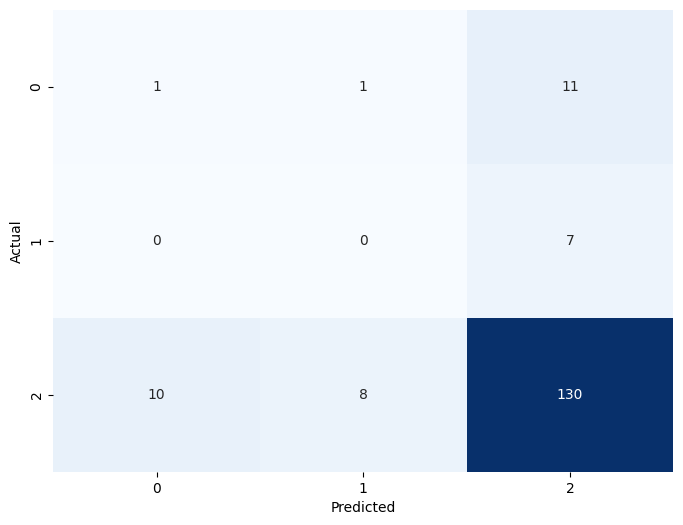

In [104]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Set the labels.
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.savefig('confussion matrix')
plt.show()

## Hyperparameters

Define the hyperparameters to study, finding the most relevants, and doing a decision tree with them.

In [105]:
# Define the hyperparameters
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}

# Do the grid search
grid_search = GridSearchCV(clf, parameters, cv=5)
grid_search.fit(X_train, y_train)

# Obtain the best hyperparameters for this situation
best_params = grid_search.best_params_

# Do the decision tree for the best hyperparameters
best_clf = tree.DecisionTreeClassifier(**best_params, class_weight=class_weights)
best_clf.fit(X_train, y_train)

# Calculate the accuaracy
accuracy = best_clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# Calculate the balanced accuracy
y_pred = best_clf.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_accuracy)


Accuracy: 0.7916666666666666
Balanced Accuracy: 0.3229383229383229


Print the classification report with other measurements.

In [106]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.09      0.08      0.08        13
         2.0       0.00      0.00      0.00         7
         3.0       0.88      0.89      0.89       148

    accuracy                           0.79       168
   macro avg       0.32      0.32      0.32       168
weighted avg       0.78      0.79      0.79       168



Plot a confusion matrix to understand correctly the results obtained previously.

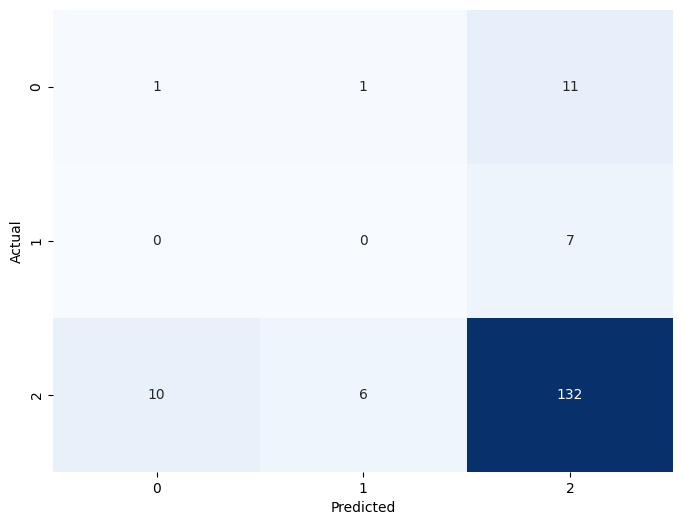

In [107]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.savefig('confussion matrix')
plt.show()

## Random forest

After that, continue exploring different models, like random forest, which does at the same time diffferent decision trees.

In [108]:
# Built a Random Forest Classifier 
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_leaf=1, min_samples_split=2, class_weight=class_weights)

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions in the test data.
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the accuracy.
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy del Random Forest:", accuracy_rf)


# Evaluate the balanced accuracy.
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_rf)
print("Balanced Accuracy:", balanced_accuracy)

Accuracy del Random Forest: 0.8809523809523809
Balanced Accuracy: 0.3333333333333333


Print the classification report with other measurements.

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.09      0.08      0.08        13
         2.0       0.00      0.00      0.00         7
         3.0       0.88      0.89      0.89       148

    accuracy                           0.79       168
   macro avg       0.32      0.32      0.32       168
weighted avg       0.78      0.79      0.79       168



Plot a confusion matrix to understand correctly the results obtained previously.

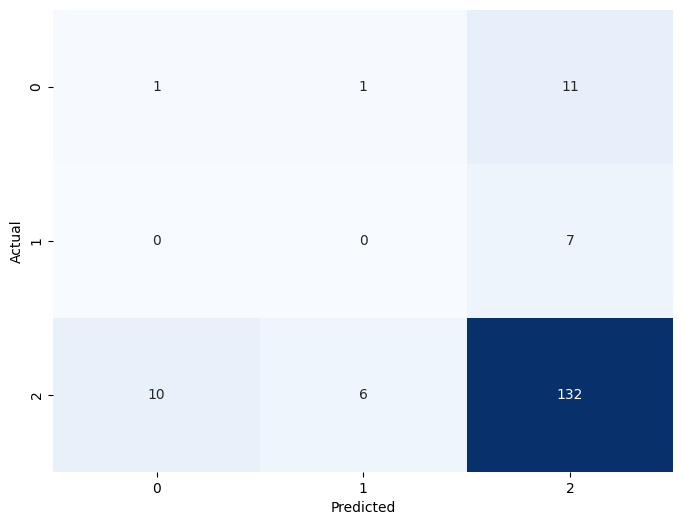

In [110]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.savefig('confussion matrix')
plt.show()

## SVM: Super Vector Machine

 Develop a Supper Vector Machine, as other model to do the calculate the classification.

In [111]:
# Built a Super Vector Machine 
svm = SVC(class_weight=class_weights)

# Train the SVM model.
svm.fit(X_train, y_train)

# Make predictions in the test data.
y_pred = svm.predict(X_test)

# Evaluate the accuracy.
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo SVM: {:.4f}".format(accuracy))

# Evaluate the balanced accuracy.
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_accuracy)

Precisión del modelo SVM: 0.6548
Balanced Accuracy: 0.3165033165033165


Print the classification report with other measurements.

In [112]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.04      0.08      0.06        13
         2.0       0.05      0.14      0.08         7
         3.0       0.86      0.73      0.79       148

    accuracy                           0.65       168
   macro avg       0.32      0.32      0.31       168
weighted avg       0.76      0.65      0.70       168



Plot a confusion matrix to understand correctly the results obtained previously.

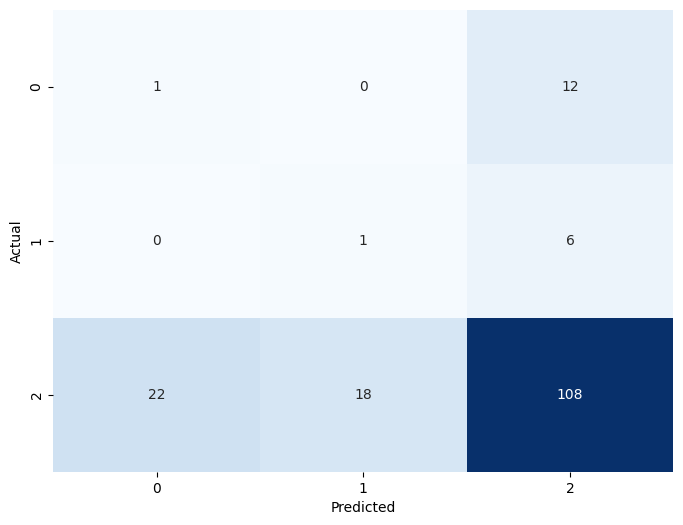

In [113]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.savefig('confussion matrix')
plt.show()

## Importance features

Now we evaluate the features by their importance

In [114]:
# Load the function 
importances = clf.feature_importances_

# Obtain the features names
feature_names = X.columns

# Sort them by importance
indices = np.argsort(importances)[::-1]

sorted_feature_names = [feature_names[i] for i in indices]

# Show them
sorted_feature_names

['WHR_bayesr',
 'BW_bayesr',
 'CAD_bayesr',
 'SBPmanual_bayesr',
 'SleepDuration_bayesr',
 'AD2_bayesr',
 'ExtremeBMI_bayesr',
 'HbA1c_bayesr',
 'ExtremeWHR_bayesr',
 'Overweight_bayesr',
 'BD_bayesr',
 'Bwfetal_bayesr',
 'RA_bayesr',
 'MDD_bayesr',
 'CKD_European_bayesr',
 'EA_bayesr',
 'ChildhoodObesity_bayesr',
 'Adiponectin_bayesr',
 'Ad_no_APOE_bayesr',
 'WC_bayesr',
 'LDL_bayesr',
 'BL_bayesr',
 'Bwmaternal_bayesr',
 'ExtremeHeight_bayesr',
 'ObesityClass3_bayesr',
 'ObesityClass1_bayesr',
 'DC2_bayesr',
 'SHR_bayesr',
 'EA22_bayesr',
 'SBPauto_bayesr',
 'InfantHeadCircumference_bayesr',
 'family_AD_bayesr',
 'PubertalGrowth_bayesr',
 'ASD_bayesr',
 'T2D_bayesr',
 'ObesityClass2_bayesr',
 'HDL_bayesr',
 'Chronotype_bayesr',
 'TC_bayesr',
 'BMI_bayesr',
 'HC_bayesr',
 'CKD_transEthnic_bayesr',
 'TG_bayesr',
 'AD1_bayesr',
 'PD_bayesr']

And plot them to have them in a more visual way

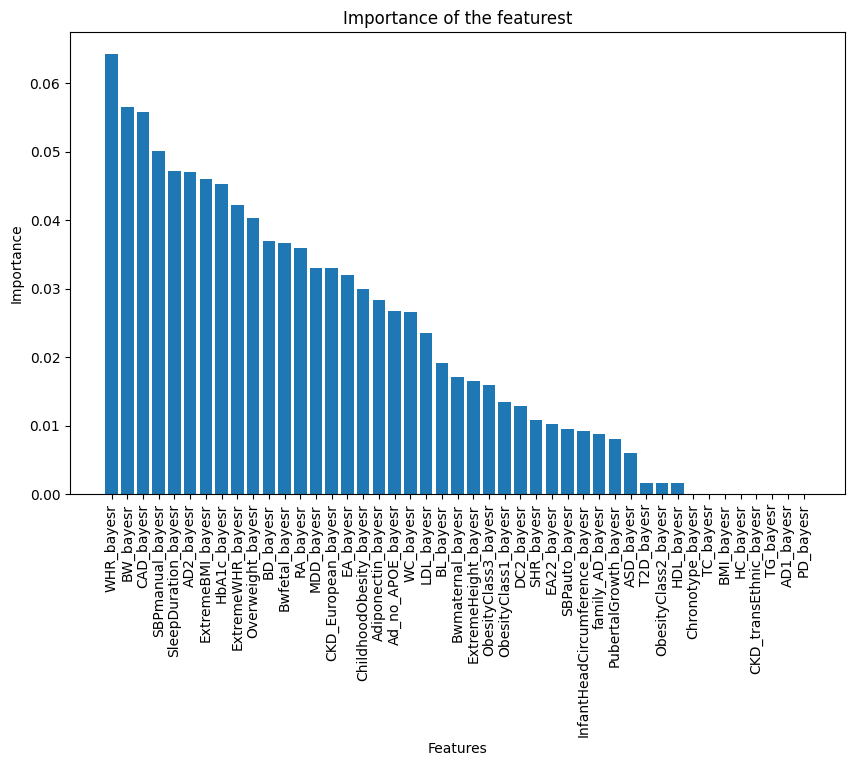

In [115]:
# Create a figure to plot them
plt.figure(figsize=(10, 6))

# Do a bar plot 
plt.bar(range(len(importances)), importances[indices])

# X axis is for the name of the features
plt.xticks(range(len(importances)), feature_names[indices], rotation='vertical')

# Add labels
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Importance of the featurest')

# Show 
plt.savefig('Importance of features')
plt.show()

## Check with heigths

Now do it with the hight


In [116]:
X = pgs_filtered
X = X.drop(['SampleID', 'UniqueID'], axis=1)

Obtain the data from the column heigth_A instead of from the traject one, and substitute the NaN values by the median 

In [117]:
y_h = phenotype_filtered['heigth_A']
median = y.median()
y_h = y_h.fillna(median)
y_h

1      3.00
2      1.80
3      1.70
4      3.00
5      1.89
       ... 
917    1.84
918    1.95
919    1.97
920    1.80
921    1.80
Name: heigth_A, Length: 837, dtype: float64

Divide it in 3 groups, based on the percentiles.

In [118]:
perc_33 = np.percentile(y_h, 15)
perc_66 = np.percentile(y_h, 85)

In [119]:
(perc_33, perc_66)

(1.77, 1.92)

In [120]:
# Create a list to keep the groups obtanied
y = []

# Split data in the two groups established (low, moderate and high, or 1, 2 and 3)
for value in y_h:
    if value >= perc_66:
        y.append(3)
    elif perc_33 <= value <= perc_66:
        y.append(2)
    else:
        y.append(1)

# Print the results
print(y)

[3, 2, 1, 3, 2, 2, 2, 1, 1, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3, 1, 2, 2, 2, 1, 2, 1, 2, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 3, 2, 1, 2, 2, 2, 2, 1, 3, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 1, 2, 2, 1, 1, 1, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 1, 3, 2, 2, 2, 1, 2, 3, 2, 2, 2, 3, 1, 3, 1, 2, 2, 1, 2, 1, 3, 1, 2, 2, 3, 2, 2, 2, 1, 2, 3, 1, 2, 2, 3, 2, 3, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 3, 3, 2, 2, 2, 2, 1, 3, 1, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 1, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 1, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 1, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 1, 1, 2, 3, 2, 2, 3, 2, 2, 

Do a dictionary with that, so can be changed to a data frame

In [122]:
dic = {'heigth_A': y}

Convert the dictionary into a data frame

In [124]:
y = pd.DataFrame(dic)

Check if it works

In [125]:
y.head()

,heigth_A
0,3
1,2
2,1
3,3
4,2


Reset the index to use the function.

In [126]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)


Use the function to change the outliers by the median of each column. 

In [127]:
X_clean, y_clean = CustomSampler_IQR(X, y)

Check there are no missing values

In [128]:
missing_values_PGS = X_clean.isnull()
missing_values_Phenotype = y_clean.isnull()

#print(missing_values_PGS.sum())
print(missing_values_Phenotype.sum())

heigth_A    0
dtype: int64


Split the data

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)
print("Training data:", X_train.shape)
print("Test data:", X_test.shape)

Training data: (669, 45)
Test data: (168, 45)


#### Hyperparameters

In [130]:
# Define the hyperparameters
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}

# Do the grid search
grid_search = GridSearchCV(clf, parameters, cv=2)
grid_search.fit(X_train, y_train)

# obtain the best hyperparameters for this situation
best_params = grid_search.best_params_

# train the decision tree for the best hyperparameters
best_clf = tree.DecisionTreeClassifier(**best_params, class_weight=class_weights)
best_clf.fit(X_train, y_train)

# Calculate the accuaracy
accuracy = best_clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# Calculate the balanced accuracy
y_pred = best_clf.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_accuracy)

Accuracy: 0.6726190476190477
Balanced Accuracy: 0.32471264367816094


Print the classification report with other measurements.

In [132]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        20
           2       0.69      0.97      0.81       116
           3       0.00      0.00      0.00        32

    accuracy                           0.67       168
   macro avg       0.23      0.32      0.27       168
weighted avg       0.48      0.67      0.56       168



C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: Undefin

Plot a confusion matrix to understand correctly the results obtained previously.

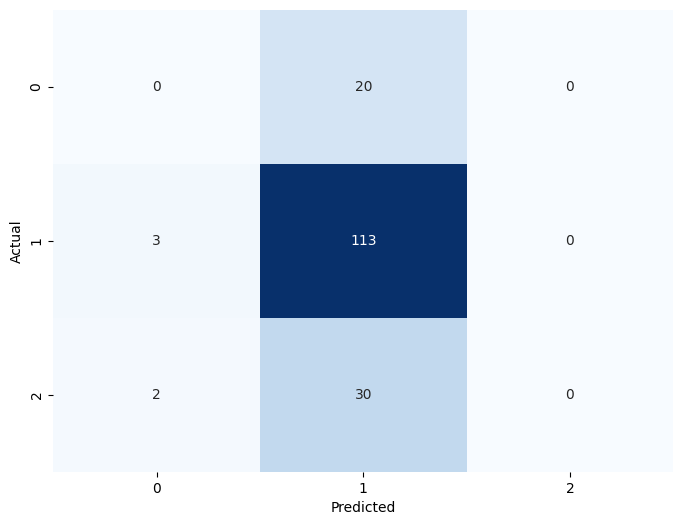

In [131]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.savefig('confussion matrix')
plt.show()

#### Random forest


In [133]:
# Built a Random Forest Classifier with the best hyperparameters defined previously
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_leaf=1, min_samples_split=2, class_weight=class_weights)

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions in the test data.
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the accuracy.
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy del Random Forest:", accuracy_rf)

# Evaluate the balanced accuracy.
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_rf)
print("Balanced Accuracy:", balanced_accuracy)

C:\Users\PC\AppData\Local\Temp\ipykernel_3560\2942838050.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


Accuracy del Random Forest: 0.6904761904761905
Balanced Accuracy: 0.3333333333333333


Print the classification report with other measurements.

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        20
           2       0.69      0.97      0.81       116
           3       0.00      0.00      0.00        32

    accuracy                           0.67       168
   macro avg       0.23      0.32      0.27       168
weighted avg       0.48      0.67      0.56       168



C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: Undefin

Plot a confusion matrix to understand correctly the results obtained previously.

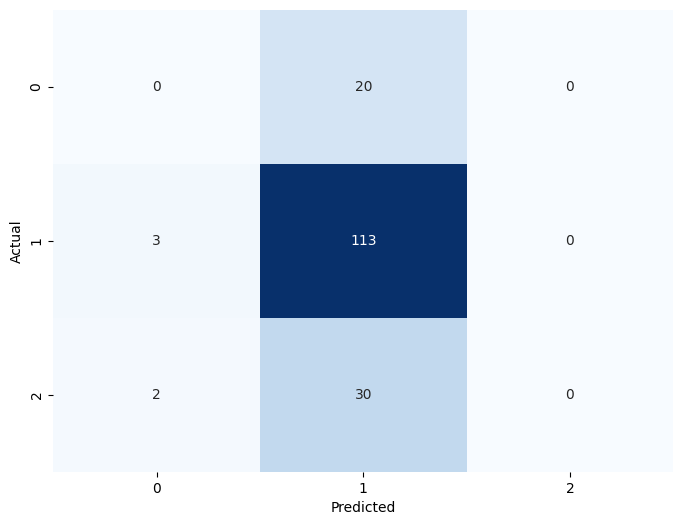

In [134]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.savefig('confussion matrix')
plt.show()